In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv("/content/merged.csv", parse_dates=["timestamp", "Date"])

<ipython-input-39-1f296efd4522>:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/merged.csv", parse_dates=["timestamp", "Date"])
<ipython-input-39-1f296efd4522>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("/content/merged.csv", parse_dates=["timestamp", "Date"])


In [ ]:
df['side'] = df['side'].map({'BUY': 1, 'SELL': 0})
df['direction'] = df['direction'].map({'BUY': 1, 'SELL': 0})
df['crossed'] = df['crossed'].astype(bool)


In [ ]:
sentiment_map = {
    'Fear': 20, 'Neutral': 50, 'Greed': 70, 'Extreme Greed': 80,
    'Extreme Fear': 10
}
df['sentiment_score'] = df['classification'].map(sentiment_map)


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

<ipython-input-42-6b1e6b0a678c>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


In [ ]:
df['profitability'] = df['closed_pnl'] - df['fee']
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek


In [ ]:
drop_cols = ['account', 'coin', 'timestamp_ist', 'transaction_hash',
             'order_id', 'trade_id', 'timestamp', 'Date', 'classification','closed_pnl','fee']
df_clean = df.drop(columns=drop_cols)


In [ ]:
df_clean.fillna(0, inplace=True)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean.drop(columns=['profitability']))


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df['pca1'] = pca_result[:, 0]
df['pca2'] = pca_result[:, 1]


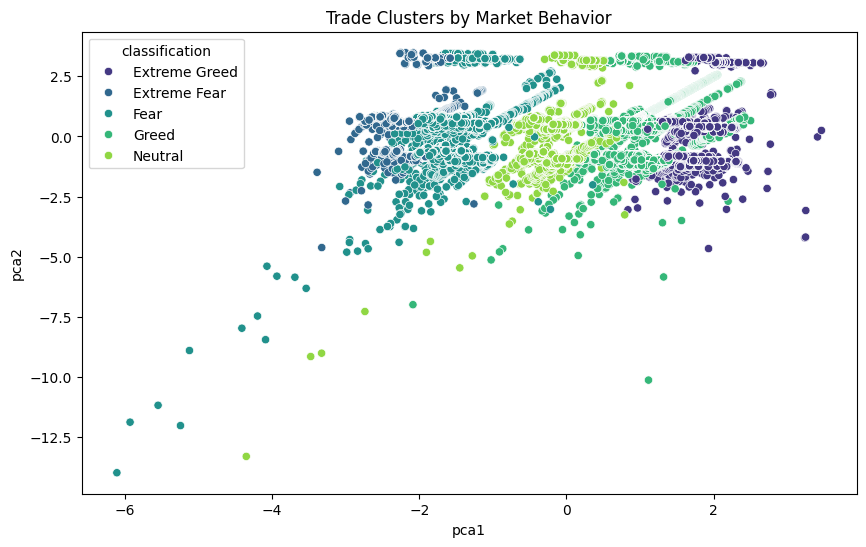

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='classification', data=df, palette='viridis')
plt.title('Trade Clusters by Market Behavior')
plt.show()


In [ ]:
X = df_clean.drop(columns='profitability')
y = df_clean['profitability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model RMSE: {rmse:.4f}")


Model RMSE: 1118.4743


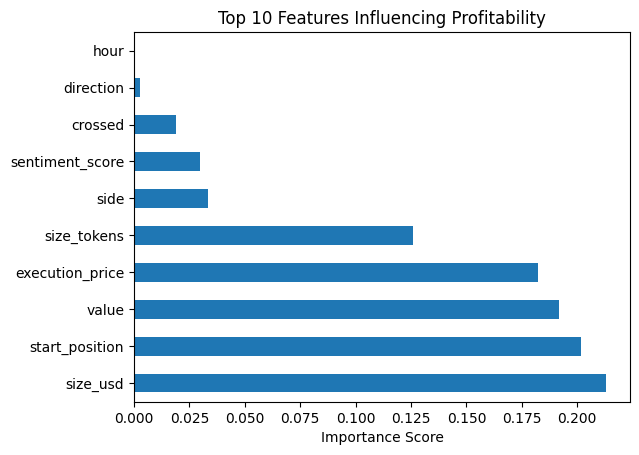

In [ ]:
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Top 10 Features Influencing Profitability')
plt.xlabel("Importance Score")
plt.show()